In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2023-02-06 16:07:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  8.92MB/s    in 2m 46s  

2023-02-06 16:10:46 (7.31 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [12]:
!mv cc.ar.300.vec.gz /content/drive/MyDrive/thesis/models/cc.ar.300.vec.gz

In [20]:
!gzip -dk cc.ar.300.vec.gz


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/models')

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras import layers
from utility import process_md_lines

In [6]:

training_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/training.txt','r',encoding='utf-8').readlines()
testing_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/testing.txt','r',encoding='utf-8').readlines()
validation_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/validation.txt','r',encoding='utf-8').readlines()

In [7]:
training_df = process_md_lines(training_lines)
testing_df = process_md_lines(testing_lines)
validation_df = process_md_lines(validation_lines)

In [8]:
training_df.head()

,id,text,order,total_lines,url,label
0,290,الشريان الأبهر هو أكبر شريان في الجسم وهو ينقل...,0,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
1,290,بشكل عام يكون تضيق الأبهر موجودا لدى المصاب من...,1,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
2,290,وغالبا ما يصاحب تضيق الأبهر عيوب أخرى في القلب...,2,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
3,290,تعتمد أعراض تضيق الأبهر على شدة الحالة فمعظم ا...,3,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms
4,290,قد يبدأ ظهور الأعراض على الأطفال المصابين بتضي...,4,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms


In [9]:
tclasses = training_df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [10]:
''' df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7) '''
train_df = training_df
test_df = testing_df

In [11]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_validation = validation_df['text'].to_numpy()

In [12]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()
y_validation = pd.get_dummies(validation_df['label']).to_numpy()

In [13]:
vocab = set()
count = 0
char_count = 0
for text in train_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

for text in test_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [14]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

69150

In [15]:
tokens_lens = [len(sentence.split()) for sentence in train_df['text'].to_numpy()]
SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
SEQ_LENGTH

49

In [16]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 300

In [17]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LENGTH)

In [18]:
text_vectorizer.adapt(train_df['text'].to_numpy())

In [19]:
from tqdm.auto import tqdm
from keras.initializers import Constant
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Glove':
        f = open('/content/drive/MyDrive/hamdan/embeddings/glove/vocab.txt')
        #embedding_dim = 200
    if embedding_name == 'fastText':
        f = open('/content/drive/MyDrive/thesis/models/cc.ar.300.vec')
        #embedding_dim = 300
    #elif embedding_name == 'AraVec':
        #f = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')
        #embedding_dim = 300
        
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    return embeddings_index, WORD_EMBED_SIZE


def prepare_embedding_matrix(embeddings_index, embedding_dim, VOC_SIZE, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((VOC_SIZE, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= VOC_SIZE:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix

In [20]:
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE) 
x_tokenizer.fit_on_texts(train_df['text'].to_numpy())
embedding_matrix = prepare_embedding_matrix(*prepare_embedding_index('fastText'), VOC_SIZE=VOCAB_SIZE+1, tokenizer=x_tokenizer)
embedding = layers.Embedding(VOCAB_SIZE, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),input_length=SEQ_LENGTH, trainable=True)

0it [00:00, ?it/s]

  0%|          | 0/68654 [00:00<?, ?it/s]

57920 known vectors
10734 random vectors


In [21]:
embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [22]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_classes, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 49)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 49, 300)           20745000  
                                                                 
 bidirectional (Bidirectiona  (None, 49, 128)          186880    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

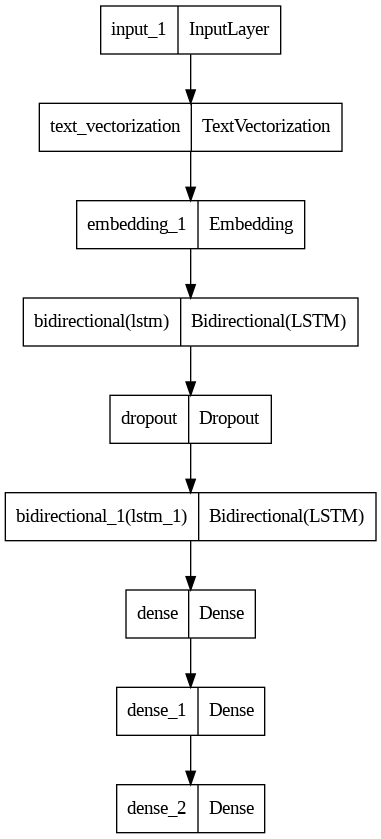

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

In [27]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [28]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[es])

Epoch 1/10
9273/9273 [==============================] - 489s 50ms/step - loss: 0.4887 - accuracy: 0.8397 - val_loss: 0.3019 - val_accuracy: 0.9056
Epoch 2/10
9273/9273 [==============================] - 455s 49ms/step - loss: 0.2046 - accuracy: 0.9353 - val_loss: 0.1955 - val_accuracy: 0.9427
Epoch 3/10
9273/9273 [==============================] - 454s 49ms/step - loss: 0.1234 - accuracy: 0.9607 - val_loss: 0.1631 - val_accuracy: 0.9554
Epoch 4/10
9273/9273 [==============================] - 456s 49ms/step - loss: 0.0914 - accuracy: 0.9703 - val_loss: 0.1509 - val_accuracy: 0.9605
Epoch 5/10
9273/9273 [==============================] - 454s 49ms/step - loss: 0.0754 - accuracy: 0.9748 - val_loss: 0.1496 - val_accuracy: 0.9641
Epoch 6/10
9273/9273 [==============================] - 454s 49ms/step - loss: 0.0662 - accuracy: 0.9775 - val_loss: 0.1390 - val_accuracy: 0.9677
Epoch 7/10
9273/9273 [==============================] - 451s 49ms/step - loss: 0.0613 - accuracy: 0.9790 - val_loss: 0

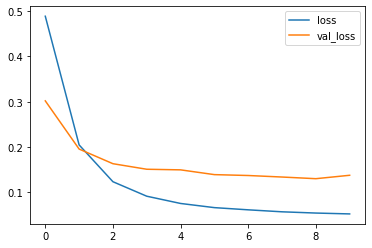

In [29]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [30]:
model.evaluate(test_ds)

1142/1142 [==============================] - 16s 14ms/step - loss: 0.1376 - accuracy: 0.9713


[0.13759559392929077, 0.9712783694267273]

In [31]:
#Test Dataset (10%)
preds = np.argmax(model.predict(X_test), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_test, cat_preds))

1142/1142 [==============================] - 20s 13ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6114
           1       0.98      0.97      0.98      6152
           2       0.97      0.96      0.96      3572
           3       0.95      0.98      0.96      7663
           4       0.99      0.98      0.98     13022

   micro avg       0.97      0.97      0.97     36523
   macro avg       0.97      0.97      0.97     36523
weighted avg       0.97      0.97      0.97     36523
 samples avg       0.97      0.97      0.97     36523



In [32]:
#Validation Dataset ( 10% )
preds_validation = np.argmax(model.predict(X_validation), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds_validation,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_validation, cat_preds))

1149/1149 [==============================] - 16s 14ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6007
           1       0.98      0.98      0.98      5901
           2       0.96      0.95      0.96      3845
           3       0.96      0.97      0.96      7853
           4       0.99      0.98      0.98     13160

   micro avg       0.97      0.97      0.97     36766
   macro avg       0.97      0.97      0.97     36766
weighted avg       0.97      0.97      0.97     36766
 samples avg       0.97      0.97      0.97     36766



In [49]:
r = np.random.randint(0,len(X_train))
text = X_train[r]
true_pred = y_train[r]
print(text)
print(true_pred)
true_pred_ = np.argmax(true_pred)
print(true_pred_)

كسر الغصن النضير في هذا النوع من الكسور يتشقق العظم ولكنه لا ينكسر تماما مثلما تحاول كسر عصا خضراء من الخشب ومعظم كسور العظام عند الأطفال هي من نوع كسر الغصن النضير نظرا لأن عظام الطفل أكثر ليونة ومرونة من عظام البالغين

[0 0 0 0 1]
4


In [50]:
myTensor = tf.convert_to_tensor(text, dtype=tf.string) 
myTensor = tf.expand_dims(myTensor,axis=-1)
class_index = np.argmax(model(myTensor))
class_index

4